# Defining all the constants required (copying them from Matlab and adjusting syntax)

In [1]:
from dolfin import *

#Importing MPI for parallel computing
# from mpi4py import MPI

# #Importing the PETSc module for parallel use
# from petsc4py import PETSc

#importing mshr for all mesh functions
import mshr as mshr

# Use SymPy to compute f from the manufactured solution u
import sympy as sym

#Option to avoid printing redundant information from each core when running the code in parallel from
#a python (.py) script obtained from the jupyter notebook.
# parallel_run = True

#MPI communicator
comm = MPI.comm_world

#Rank of each process (its ID essentially)
rank = MPI.rank(comm)

#Total number of processes
number_processes = MPI.size(comm)

print(f'This is process {rank} out of {number_processes-1}')

if number_processes <2:

    #Increasing the width of the notebook (visual difference only)
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))
    
    #have to define where to put plots BEFORE importing matplotlib
    %matplotlib notebook

#Importing matplotlib to plot the results
from matplotlib import pyplot as plt

#Importing numpy to work with arrays
import numpy as np

#Importing tempfile to save numpy arrays from the main script so we can get them back and plot them
#interatively rather than saving a pdf or png!
from tempfile import TemporaryFile

#Importing time to compute how long each segment takes
import time

#importing regex to change every instance of radius_tot so we change the ones in the C++ code
#at the same time too
import re

#varname gives the name of the variable as a string
from varname import varname

#Needed to use the 3D scatter
from mpl_toolkits.mplot3d import Axes3D

#Importing the decimal package to be able to specify arbitrary accuracy, needed e.g. when
#calculating the jacobian for the lensing
from decimal import *

#Importing all quantities, constants etc used in the calculations
from MONDquantities import *

#Importing all classes I created
from MONDclasses import *

#Importing the functions I made from the MONDfunctions file
from MONDfunctions import *

#Importing all expressions for weak forms, initial guesses/BCs and sources
from MONDexpressions import *

#Needed if want to use the adapt function for mesh refinement, see:
#https://fenicsproject.org/qa/6719/using-adapt-on-a-meshfunction-looking-for-a-working-example/
#If using 'plaza' instead of 'plaza_with_parent_facets', it's faster by about 30%! Also, I get the
#'*** Warning: Cannot calculate parent facets if redistributing cells'. So for MPI no need to use
#with parent facets!
parameters["refinement_algorithm"] = "plaza"

#Setting compiler parameters.
#Optimisation
parameters["form_compiler"]["optimize"]     = True
parameters["form_compiler"]["cpp_optimize"] = True

#Ghost mode for when using MPI. Each process gets ghost vertices for the part of the domain it does not
#own. Have to set to 'none' instead or I get Error 'Unable to create BoundaryMesh with ghost cells.'
parameters['ghost_mode'] = 'none'

This is process 0 out of 0


In [2]:
# info(parameters,True)


In [3]:
## starting time of whole PDE solver
starting_time = time.time()

#starting an empty list to contain all of the run_time objects to plot later
section_times = []

print('Starting mesh generation...\n')
mesh_generation_start = time.time()

#Making mesh from function defined above
mesh = make_spherical_mesh(domain_size, mesh_resolution)

mesh_generation_end = time.time()
mesh_generation_time = run_time(mesh_generation_end - mesh_generation_start, 'Mesh Generation')
section_times.append(mesh_generation_time)
print('Mesh generated in {} s \n'.format(mesh_generation_time.time))

#Setting the MPI communicator for the mesh (doesnt seem to do anything right now)
# mesh.mpi_comm = comm

print(f'The mesh of process {rank} has {mesh.num_cells()} cells')

Starting mesh generation...

Mesh generated in 2.6103711128234863 s 

The mesh of process 0 has 21278 cells


In [4]:
# #Defining extremes of main diagonal to obtain side_length*3 cube
# box_edge_low = Point(-domain_size/sqrt(2)*np.array([1,1,1]))
# box_edge_high = Point(domain_size/sqrt(2)*np.array([1,1,1]))

# #Using dolfin builtin mesh, defining edges and resolution for all 3 axes
# cubic_mesh = BoxMesh(comm, box_edge_low, box_edge_high, mesh_resolution, mesh_resolution, mesh_resolution)

# #Object returned by BoxMesh is not a dolfin mesh, so we define it as such to be able to use it
# cubic_mesh = Mesh(cubic_mesh)

# mesh = cubic_mesh

In [5]:
# mesh_partitioned = MeshPartitioning

# distributed_mesh = mesh_partitioned.build_distributed_mesh(mesh)

# print(mesh.mpi_comm())

mesh.bounding_box_tree().compute_first_entity_collision(Point(domain_size, domain_size/2, domain_size/2))

4294967295

In [6]:
if plotting_option:

        #Making a regular fine mesh(4 times as fine as initial unrefined mesh) to interpolate our functions over
        cubic_mesh = make_cube_mesh(2*domain_size, plot_resolution*2)

        #Getting a spherical mesh from the cube generated above, Making mesh slightly larger so we don't miss points 
        #on the surface that are absent due to the new mesh having a smooth boundary
        mesh_for_plots = circle_grid_mesh(cubic_mesh, mesh_plot_size, show_mesh=False)

#Creating a scalar function space on the large mesh, so we can interpolate functions on it and plot them
# V_plot = FunctionSpace(mesh_for_plots, 'CG', 1)

## Defining coordinates for some test mass distributions

In [7]:
#For all the points to be within a given radius, each coordinate must be smaller than
#radius_population/sqrt(3)
random_max_distance = radius_population/sqrt(3)

#Setting a given seed so we can always have the same random numbers for now
np.random.seed(1)

#We want a mean of 0 so center of mass is in center, and the same standard deviation as the gaussian
#pulse. This means we sample from the same distribution as the smooth one, and have the same mean.
#This is exactly what we want to compare coarse and smooth distributions
mu, sigma = 0, stand_dev
random_coordinates_x = np.random.normal(mu, sigma, source_number)
random_coordinates_y = np.random.normal(mu, sigma, source_number)

#If we want all source to be in the same plane, we set the z axis to be 0 for all of them. Otherwise,
#random as above
if coplanar_sources == True:
    
    random_coordinates_z = np.zeros((source_number, 1)).ravel()

else:
    
    random_coordinates_z = np.random.normal(mu, sigma, source_number)

#If we dont need Gaussian, defining a source_number*3 array of random numbers between 0 and 1 and
#multiplying by the radius just defined so all points are inside a sphere of radius_tot.
#Subtracting 0.5 so #we're sampling equally from the positive and negative instead of from 0 to 1
# random_coordinates = random_max_distance * (np.random.rand(source_number, 3)-0.5)

# Uncomment for test case with two equal masses on the xy plane at a given distance
# their_distance = 3

# # random_coordinates[0][0] = -domain_size/their_distance
if central_mass:

    random_coordinates_x[0] = 0
    random_coordinates_y[0] = 0
    random_coordinates_z[0] = 0

# random_coordinates[1][0] = domain_size/their_distance
# random_coordinates[1][1] = 0
# random_coordinates[1][2] = 0

#Overall array containing all coordinates. If over-writing the random position, this has to go after it,
#otherwise the c++ array for the source sets the wrong position!
random_coordinates = np.array((random_coordinates_x, random_coordinates_y, random_coordinates_z))
random_coordinates = np.transpose(random_coordinates)

#Obtaining the center of each source as a list of points
source_centers = [Point(random_coordinates_x[i], random_coordinates_y[i], random_coordinates_z[i]) for i in range(source_number)]

# Overriding definition with known point for testing of the mesh refinement
# test_coordinates  = 5*kp*np.zeros((3,1))
# source_centers = Point(test_coordinates)

# random_coordinates
# print(f'Mean in x: {abs(mu - np.mean(random_coordinates_x))/domain_size}\n') 
# print(f'Mean in y: {abs(mu - np.mean(random_coordinates_y))/domain_size}\n') 
# print(f'Mean in z: {abs(mu - np.mean(random_coordinates_z))/domain_size}\n') 

In [8]:
# print(f'Random coordinates are:\n {random_coordinates}')
# print(source_centers[0][1])

In [9]:
# for point in source_centers:
    
#     print(f'{point.x(), point.y(), point.z()}')

## Finding the center of mass for the mass distribution to correctly calculate BCs and initial guesses 

In [10]:
#COMMENTED OUT MOMENTARILY TO TEST HAVING SOURCE IN PLANE!
#NEED TO TEST IF THIS WORKS CORRECTLY WITH RANDOM POINTS. PRROBLEM BEOFR EWAS WITH MESH
#REFINEMENT, WASNT READING THE OOINT TO REFINE CORRECTLY!

#For the current case in which all sources have the same mass, we simply divide by #sources
center_of_mass_x = random_coordinates[:,0].sum()/source_number
center_of_mass_y = random_coordinates[:,1].sum()/source_number
center_of_mass_z = random_coordinates[:,2].sum()/source_number

#Overall center of mass
center_of_mass = [center_of_mass_x, center_of_mass_y, center_of_mass_z]

# center_of_mass = test_coordinates
# center_of_mass_x = center_of_mass[0]
# center_of_mass_y = center_of_mass[1]
# center_of_mass_z = center_of_mass[2]

# # #Overwriting center of mass to check if the BC works correctly
# # center_of_mass = [0,0,0]
# source_centers[0]/kp

# center_of_mass
print(f'Process {rank} about to refine')

Process 0 about to refine


In [11]:
print('Starting mesh refinement...\n')
mesh_refine_start = time.time()
new_mesh = more_modified_refinement(mesh, source_centers, refine_times)
# new_mesh = local_refinement(mesh, source_centers, radius_refine, refine_times, technique = 'ring')
mesh_refine_end = time.time()
mesh_refine_time = run_time(mesh_refine_end - mesh_refine_start, 'Mesh Refinement')
section_times.append(mesh_refine_time)
print('Mesh refined in {} s \n'.format(mesh_refine_time.time))

#Saving the mesh to a file so we can then retrieve it from all processes
# mesh_file = File('mesh.xml')
# mesh_file << new_mesh

Starting mesh refinement...

Iteration 1 of 10: The Cell number went from 21278 to 21526, up by a factor 1.0116552307547702

Iteration 2 of 10: The Cell number went from 21526 to 22228, up by a factor 1.0326117253553841

Iteration 3 of 10: The Cell number went from 22228 to 23099, up by a factor 1.0391848119488933

Iteration 4 of 10: The Cell number went from 23099 to 23608, up by a factor 1.0220355859561019

Iteration 5 of 10: The Cell number went from 23608 to 24091, up by a factor 1.0204591663842766

Iteration 6 of 10: The Cell number went from 24091 to 24668, up by a factor 1.023950853015649

Iteration 7 of 10: The Cell number went from 24668 to 25453, up by a factor 1.0318226041835576

Iteration 8 of 10: The Cell number went from 25453 to 26248, up by a factor 1.0312340392095234

Iteration 9 of 10: The Cell number went from 26248 to 27027, up by a factor 1.0296784516915574

Iteration 10 of 10: The Cell number went from 27027 to 29358, up by a factor 1.0862470862470863

Cell number

In [12]:
#Trying to save a mesh to a file and then load it from each process so there's no need to broadcast it!
#Doesnt seem to work for now though
# mesh_from_file = Mesh('mesh.xml')
# mesh = mesh_from_file

mesh = new_mesh

# Gathering all the data from the mesh AFTER having done the mesh refinement and defined the mesh for plotting

In [13]:
# mesh.mpi_comm = comm
# mesh.mpi_comm

In [14]:
print('Rearranging mesh data\n')
rearrange_start = time.time()

#IMPORTANT: Tried solving the whole PDE with degree 2, so that taking the Laplacian of the solution would
#give a smoother expression. However, that did not work for mesh resolution = 21 ,it takes up too much
#memory and cant be run. Can solve up to degree 3 but with low resolution = 11. Can't do degree = 4!
#The alternative is to take the solution itself and take its Laplacian and project it on a degree 3 space
#Calling the rearrange_mesh_data function to get coordinates and order them based on the 
#distance from the center of mass
V, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted = rearrange_mesh_data(mesh, center_of_mass, degree_PDE)

#To be able to gather the coordinate arrays with MPI, the coordinates need to be C_contiguous
x_coords, y_coords, z_coords, r_coords = [np.ascontiguousarray(coord_array) for coord_array in [x_coords, y_coords, z_coords, r_coords]]

rearrange_end = time.time()
rearrange_time = run_time(rearrange_end - rearrange_start, 'Mesh data rearrange')
section_times.append(rearrange_time)
print('Mesh data rearranged in {} s \n'.format(rearrange_time.time))

Rearranging mesh data

Mesh data rearranged in 0.12645292282104492 s 



In [15]:
# test_string = make_discrete_gauss(10)
# print(f'The generated string is:\n {test_string},\n The normal string is:\n {f_exponent_test}')

# Defining a few BVP from combinations we use often. Naming scheme: 'weak form_source'

In [16]:
#BVPs for a discrete dirac mass distribution, for Newton and MOND with/out interpolations
newton_dirac = BVP(F_Newton, u_Newton, f_multiple_dirac, 'Newton, discrete dirac')
mond_deep_dirac = BVP(F_MOND_deep, u_displaced_cpp, f_multiple_dirac, 'Deep MOND, discrete dirac')
mond_simple_dirac = BVP(F_MOND_simple, u_displaced_cpp, f_multiple_dirac, 'Simple MOND, discrete dirac')
mond_standard_dirac = BVP(F_MOND_standard, u_displaced_cpp, f_multiple_dirac, 'Standard MOND, discrete dirac')

#BVPs for a discrete gauss mass distribution.
newton_gauss = BVP(F_Newton, u_Newton, f_multiple_gauss, 'Newton, discrete gauss')
mond_deep_gauss = BVP(F_MOND_deep, u_displaced_cpp, f_multiple_gauss, 'Deep MOND, discrete gauss')
mond_simple_gauss = BVP(F_MOND_simple, u_displaced_cpp, f_multiple_gauss, 'Simple MOND, discrete gauss')
mond_standard_gauss = BVP(F_MOND_standard, u_displaced_cpp, f_multiple_gauss, 'Standard MOND, discrete gauss')

#BVPs for a continuous distribution, for Newton and MOND with/out interpolations
newton_continuous = BVP(F_Newton, u_Newton, f_exponent_test, 'Newton, continuous gauss')
mond_deep_continuous = BVP(F_MOND_deep, u_displaced_cpp, f_exponent_test, 'Deep MOND, continuous gauss')
mond_simple_continuous = BVP(F_MOND_simple, u_displaced_cpp, f_exponent_test, 'Simple MOND, continuous gauss')
mond_standard_continuous = BVP(F_MOND_standard, u_displaced_cpp, f_exponent_test, 'Standard MOND, continuous gauss')

#BVPs for a three parameter beta distribution
newton_beta = BVP(F_Newton, u_Newton, f_gas_three_beta, 'Newton, beta')
mond_deep_beta = BVP(F_MOND_deep, u_sphere_cpp, f_gas_three_beta, 'Deep MOND, beta')
mond_simple_beta = BVP(F_MOND_simple, u_sphere_cpp, f_gas_three_beta, 'Simple MOND, beta')
mond_standard_beta = BVP(F_MOND_standard, u_sphere_cpp, f_gas_three_beta, 'Standard MOND, beta')

# Trying an alternative method for assigning values inside the c++ expressions by using exec, to avoid the limit on eval!

In [17]:
# test_string = make_source_string(10)
# test_string

In [18]:
#Defining a function for the boundary. Since we only have one BC for the whole boundary, we
#can make a simple function that returns true for each value on the boundary
#the on_boundary built-in function takes each point in domain and returns true if on boundary
def boundary(x, on_boundary):
    return on_boundary

In [19]:
def solve_PDE(the_BVP):
    '''Function takes in a BVP object, which defines the weak form, initial guess/BC and source for
    a PDE, and computes its solution'''
    
    ## starting time of PDE solver
    solver_start = time.time()
    print('Starting PDE Solver...\n')

    #defining the x,y,z coordinates from the coordinate array in sympy
#     x, y, z = sym.symbols('x[0], x[1], x[2]')

    #VERY IMPORTANT: If using sympy, use sym. in front of every mathematical operator, or the sym. and UFL (the
    #mathematical syntax used in fenics) collide and an error about UFL conversion appears
    
    #Defining the source term here, cause the make_source_string function creates a string that 
    #evaluate the expression for a variable called 'source'
    source = the_BVP.source
    
    #Evaluating the source term obtained from the make_source_string function
    f = eval(make_source_string(source_number))
    
    #Declaring the expression for the initial guess
    u = (Expression(the_BVP.initial_guess,
    degree = degree_PDE, a0 = a0, ms = ms,mgb = mgb, G = G,  ly = ly, kp = kp, radius_tot = radius_tot,
    volume_out = volume_out, center_of_mass_x = center_of_mass_x,
    center_of_mass_y = center_of_mass_y, center_of_mass_z = center_of_mass_z,
    source_number = source_number, source_mass = source_mass))

    #Declaring the expression for the boundary condition with displaced CM (center of mass)
    boundary_CM = u

    #Declaring the boundary condition. It takes three arguments: function space, value of BC, 
    #section of the boundary (in our case the whole boundary).
    bc = DirichletBC(V, boundary_CM, boundary)

    #Defining the variational problem
    #u is the solution. for linear problems, we'd have to define it as TrialFunction, but for 
    #non-linear we define it as Function directly
    u = interpolate(u, V)

    #defining the test function
    v = TestFunction(V)

    #defining the weak form to be solved
    F = eval(the_BVP.weak_form)

    #Computing the solution for normal deep MOND
    (solve(F == 0, u, bc, solver_parameters={"newton_solver":{"relative_tolerance":1e-6},
                                             "newton_solver":{"maximum_iterations":200}}))

    solver_end = time.time()
    solver_time = run_time(solver_end - solver_start, 'PDE Solver')
    section_times.append(solver_time)

    print('PDE solved in {}\n'.format(solver_time.time))
    
    return u, f

In [20]:
#Waiting for each process to have completed before moving on to solve the PDE
# MPI.barrier(comm)

In [21]:
#Defined the quantity BVP_to_solve in the MONDquantities file as a string, so to use it we need to 
#evaluate it with eval.
u, f = solve_PDE(eval(BVP_to_solve))

Starting PDE Solver...

PDE solved in 79.10345935821533



# Plots
## First, the potential

### Defining a function to set x,y,z axes labels and ticks

## Finding the values of the function, its gradient and the source at each vertex of the mesh, and the coordinates at each point of the mesh

In [22]:
data_collection_start = time.time()
print('Collecting data from PDE...\n')

if plotting_option == True:
    mesh = mesh_for_plots
    V_plot, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted = rearrange_mesh_data(mesh, center_of_mass)
    u_plot = interpolate(u, V_plot)
    f_plot = interpolate(f, V_plot)
    u = u_plot
    #Calling the rearrange_mesh_data function to get coordinates and order them based on the 
    #distance from the center of mass

#These options that are commented out were an attempt to solve the PDE on a lower degree, then 
#project it on a higher degree space. Doesnt work very well as you cant project a degree 1 on a degree 2
#properly. It's essentially asking a quadratic form from a linear form for each element
# #setting the degree for the function space onto which we want to project the solution 
# higher_degree = 3

# #Function space for higher_degree
# V_higher_degree = FunctionSpace(mesh, 'CG', higher_degree)

# #Solution projected over the higher degree function space
# u_higher_degree = project(u, V_higher_degree)

# #Assigning the higher degree solution to u and doing all calculations with this
# u = u_higher_degree


#The value of the function at each vertex of the mesh is stored in a np array. Its order
#corresponds to the otder of the mesh.coordinates() values
potential = u.compute_vertex_values()

#The value of the source at each vertex of the mesh
source = 1/(4*pi*G)*f.compute_vertex_values(mesh)

#Getting the degree from the scalar function space V from the PDE
degree = V.ufl_element().degree()

# #Setting the degree for all projections equal to the degree we use for the projection of the solution
# #above
# degree = higher_degree


#Laplacian of the solution to get back the scaled mass distribution
lap = div(grad(u))

apparent_mass_project = project(lap, V)

if lensing_interpolations:

    #For integration, we can only act on (scalar) FunctionSpace. Hence, we project each derivative
    #of u individually onto the same function space as u
    #If having problem with space, check the page that suggested this
    #https://fenicsproject.org/qa/3688/derivative-in-one-direction/
    acceleration_project_vector = [project(u.dx(i), V) for i in range(3)]

    #Declaring a tensor(matrix) function space onto which to project the Jacobian of the potential
    T = TensorFunctionSpace(mesh, 'P', degree)

    #Projecting the gradient of the gradient (jacobian) of the potential onto TensorFunctionSpace
    lensing_jacobian_project = project(grad(acceleration_project), T)

    #First, getting each element of the lensing jacobian into a 1*9 list by differentiating each
    #element of the acceleration list w.r.t. each coordinate. List is handy to loop over
    #with only one index, e.g. to integrate or graph
    lensing_jacobian_project_list = ([project(acceleration_project_vector[i].dx(j), V) 
                                        for i in range(3) for j in range(3)])

    #Next, reshaping the list into a 3x3 array so we can access it by pair of coordinates
    lensing_jacobian_project_matrix = np.reshape(lensing_jacobian_project_list,(3,3))

    #Putting the values of the Jacobian into a np array
    lensing_jacobian_magnitude = lensing_jacobian_project.compute_vertex_values()

    #Reshaping the lensing jacobian into a matrix of vectors, an order 3 tensor, to have the value
    #the jacobian at each point in space, like with the acceleration
    lensing_jacobian_magnitude = (np.reshape(lensing_jacobian_magnitude, (3, 3,
                                             int(lensing_jacobian_magnitude.shape[0]/9))))    

#Projecting the acceleration onto a vector space is expensive, so don't do it unless needed
#If not needed, set acceleration to 0 everywhere
if acceleration_needed:
    
    #To obtain the values for the acceleration, we need to define a new function space, since the 
    #gradient is a vector function is the function space for the PDE is a scalar function space
    W = VectorFunctionSpace(mesh, 'P', degree)
    
    #Projecting (similar to interpolating) the grad(u) field onto W, gives a function
    acceleration_project = project(grad(u), W)

    #The result of project is n*3,1 np.array, with 3 (x,y,z) values for each of the n vertices
    acceleration = acceleration_project.compute_vertex_values()
    
    #reshaping the array to split the x,y,z components into their own column each
    acceleration = np.reshape(acceleration, (3, int(acceleration.shape[0]/3)))
    
else:
    
    acceleration = np.zeros((3, len(potential)))
    

acceleration_x = acceleration[0]
acceleration_y = acceleration[1]
acceleration_z = acceleration[2]

#Finding the magnitude of the acceleration
acceleration_magnitude = np.linalg.norm(acceleration, axis=0)

#Sorting the potential, acceleration and source according to thr r of the vertex they pertain to
potential_sorted = potential[sorting_index]
acceleration_magnitude_sorted = acceleration_magnitude[sorting_index]
source_sorted = source[sorting_index]

data_collection_end = time.time()
data_collection_time = run_time(data_collection_end - data_collection_start, 'Data Collection')
section_times.append(data_collection_time)
print('Data collected in {} s\n'.format(data_collection_time.time))


Data collected in 2.792229413986206 s



# Calculating the Laplacian of the potential to obtain the apparent dark matter distribution.

In [63]:
#The apparent mass distribution is the RHS of the Newtonian Poisson equation. No need to scale it as it
#is already scaled in the expression for the source itself
# apparent_mass_divergence = div(acceleration_project)

# #Projecting the divergence above onto the same scalar function space as the potential
# apparent_mass_project = project(apparent_mass_divergence, V)

integral = assemble(lap*dx)

#Gathering the values of the mass distribution 
apparent_mass_distribution = 1/(4*pi*G)*apparent_mass_project.compute_vertex_values()

#Sorting the mass distribution values
apparent_mass_distribution_sorted = apparent_mass_distribution[sorting_index]

(integral/(4*pi*G))/mgb

5.334041614815104

# Gathering the potential and coordinate numpy array onto process 0 to have the full solution.

In [24]:
#First, we need to know how many vertices we have in total in the full mesh to preallocate the array
#for both the potential and the coordinates. We do this with the MPI reduce operation MPI_SUM
print(f'Process {rank}: potential has {len(potential)} elements.')

#We need the total #vertices as an int to define an array. Calling MPI.sum with communicator and
#value to be summed from each process
total_mesh_vertices = int(MPI.sum(comm, len(potential)))

if rank == 0:

    print(f'Process {rank}: the overall potential has {total_mesh_vertices} elements.')

#Now we can gather all values of the potential and coordinates. First, we define arrays to hold the
#result, the size of the total potential on process 0

#Have to initialise the receving buffer for the potential to None on all processes or we get an error
potential_total = None
x_coords_total = None
y_coords_total = None
z_coords_total = None
r_coords_total = None
source_total = None
apparent_mass_total = None

if rank == 0:
    
    #There is a problem with the receive buffer not being big enough. A simple fix for now is to 
    #multiply its size by 1.5, then we can remove all the trailing zeros
    receiver_size = int(1.5*total_mesh_vertices)

    potential_total = np.empty(receiver_size, dtype = type(potential[0]))
    x_coords_total = np.empty(receiver_size, dtype = type(x_coords[0]))
    y_coords_total = np.empty(receiver_size, dtype = type(x_coords[0]))
    z_coords_total = np.empty(receiver_size, dtype = type(x_coords[0]))
    r_coords_total = np.empty(receiver_size, dtype = type(x_coords[0]))
    source_total = np.empty(receiver_size, dtype = type(potential[0]))
    apparent_mass_total = np.empty(receiver_size, dtype = type(potential[0]))
    
#IMPORTANT: Have to use Gatherv, not Gather, or it won't work!
comm.Gatherv(potential, potential_total, root = 0)
comm.Gatherv(x_coords, x_coords_total, root = 0)
comm.Gatherv(y_coords, y_coords_total, root = 0)
comm.Gatherv(z_coords, z_coords_total, root = 0)
comm.Gatherv(r_coords, r_coords_total, root = 0)
comm.Gatherv(source, source_total, root = 0)
comm.Gatherv(apparent_mass_distribution, apparent_mass_total, root = 0)

Process 0: potential has 5396 elements.
Process 0: the overall potential has 5396 elements.


In [25]:
#Now we want to sort as usual, now for the total potential and based on the overall r coordinates

if rank == 0:

    #Storing the index to sort according to the total r
    sorting_index_total = r_coords_total.argsort()

    #Sorting all total quantities
    r_total_sorted = r_coords_total[sorting_index_total]
    
    x_total_sorted = x_coords_total[sorting_index_total]
    
    y_total_sorted = y_coords_total[sorting_index_total]
    
    z_total_sorted = z_coords_total[sorting_index_total]
    
    potential_total_sorted = potential_total[sorting_index_total]
    
    source_total_sorted = source_total[sorting_index_total]
    
    apparent_mass_total_sorted = apparent_mass_total[sorting_index_total]
    
    #Finding the zero elements in the sorted r array, and removing them. We do this by only keeping the
    #Finding the indices for which r is larger than the smallest r on process 0, divided by 10**5 just to
    #make sure. There should definitely not be any mesh points with distances smaller than that!
    total_nonzero_indices = (r_total_sorted > r_sorted[0]/(10**5))
    
    #Taking the non-padding components of radius, potential, source and mass distribution
    x_total_sorted = x_total_sorted[total_nonzero_indices]
    y_total_sorted = y_total_sorted[total_nonzero_indices]
    z_total_sorted = z_total_sorted[total_nonzero_indices]
    r_total_sorted = r_total_sorted[total_nonzero_indices]
    potential_total_sorted = potential_total_sorted[total_nonzero_indices]
    source_total_sorted = source_total_sorted[total_nonzero_indices]
    apparent_mass_total_sorted = apparent_mass_total_sorted[total_nonzero_indices]
    
    #The dark matter is the difference between the apparent and source masses
    dark_mass_total_sorted = apparent_mass_total_sorted - source_total_sorted
    
    #Saving all these numpy arrays so we can plot them again in Python, instead of just having a saved figure
    #that is not interactive!
    
    #Declaring all the temporary files we want to write to
#     potential_saved = TemporaryFile()
#     source_saved = TemporaryFile()
#     apparent_mass_saved = TemporaryFile()
#     r_sorted_saved = TemporaryFile()
    
    #Saving all the quantities to the respective files
    np.save('Numpy_Arrays/potential_saved.npy', potential_total_sorted)
    np.save('Numpy_Arrays/source_saved.npy', source_total_sorted)
    np.save('Numpy_Arrays/apparent_mass_saved.npy', apparent_mass_total_sorted)
    np.save('Numpy_Arrays/dark_mass_saved.npy', dark_mass_total_sorted)
    np.save('Numpy_Arrays/x_sorted_saved.npy', x_total_sorted)
    np.save('Numpy_Arrays/y_sorted_saved.npy', y_total_sorted)
    np.save('Numpy_Arrays/z_sorted_saved.npy', z_total_sorted)
    np.save('Numpy_Arrays/r_sorted_saved.npy', r_total_sorted)

<IPython.core.display.Javascript object>


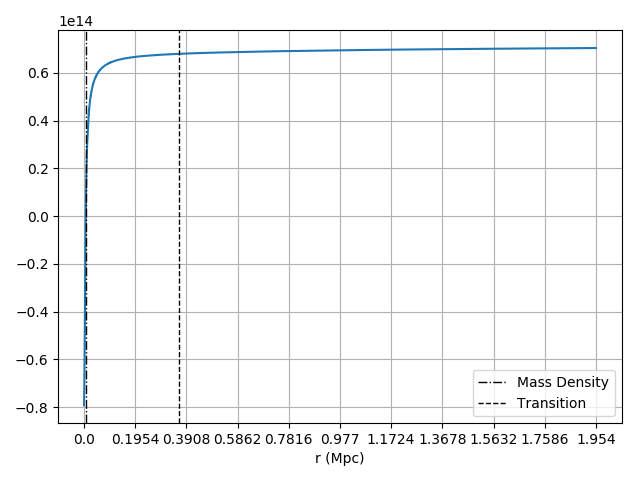

In [26]:
if rank == 0:

    fig, fig_total_potential = plt.subplots(sharex=True, sharey=True)

    fig_total_potential.plot(r_total_sorted, potential_total_sorted)
    
    plot_annotations(fig_total_potential)

    #Formatting plot using the function I made
    plot_format(fig_total_potential,1,1)
    
    #Saving the figure in the Figure folder, removed padding arounf with bbox_inches and 
    plt.savefig(f'Figures/total_potential.pdf', bbox_inches='tight')

In [27]:
if rank == 0:

    print(f'potential_total has length {len(potential_total)}')
    
    potential_total_no_zeros = potential_total[np.nonzero(potential_total)]

    print(f'potential_total_no_zeros has length {len(potential_total_no_zeros)}')
    
    
    print(f'x_coords has length: {len(x_coords)}')
    print(f'x_coords_total has length: {len(x_coords_total)}')
    # x_coords_total
    x_total_no_zeros = x_coords_total[np.nonzero(x_coords_total)]
    print(f'x_total_no_zeros has length: {len(x_total_no_zeros)}')

potential_total has length 8094
potential_total_no_zeros has length 8055
x_coords has length: 5396
x_coords_total has length: 8094
x_total_no_zeros has length: 8055


# Gathering the apparent_mass distribution onto process 0 exactly as we did for potential

## Integrating quantitites along a straight line

In [28]:
if lensing_interpolations:
    
    #Defining starting and ending point for the integration, at two ends of a line on xy-plane
    #Multiplying vertices by 0.99 to avoid asking for points outside the domain 
    starting_point = np.array([0, 0, domain_size*0.99])
    ending_point = np.array([0, 0, -domain_size*0.99])

    #using the line_integral function defined above
    potential_integrated = line_integral(u, starting_point, ending_point, n=100)

    #Integrating all components of the lensing Jacobian
    lensing_jacobian_integrated_list = ([line_integral(component,starting_point,ending_point,n=100)
                                   for component in lensing_jacobian_project_list])

    #Putting the list in matrix form, can be handier to access
    lensing_jacobian_integrated_matrix = np.reshape(lensing_jacobian_integrated_list,(3,3))

    #We only need the Jacobian in a plane. In our case, our integration path given by starting_point
    #and ending_point is along the z axis, so we're interested in the xy Jacobian, [0:1,0:1]
    lensing_jacobian_xy_plane = lensing_jacobian_integrated_matrix[0:2, 0:2]

    #We now obtain the quantities needed for the lensing formalism as described at:
    #https://en.wikipedia.org/wiki/Gravitational_lensing_formalism#Lensing_Jacobian

    #First, the distance between observer and lens. We set the observer and source to be the 
    #starting and end_points
    observer_lens_Dd = domain_size

    #Then, distance between source and lens
    source_lens_Dds = domain_size

    #And the overall distance between source and observer
    source_observer_Ds = observer_lens_Dd + source_lens_Dds

    #Now we find the Jacobian in the xy plane
    jacobian_xy_plane_A = (np.eye(2) - 2*source_lens_Dds/(observer_lens_Dd*source_observer_Ds*c**2)*
                           lensing_jacobian_xy_plane)

    #PROBLEM: The value of the Jacobian for the current values is too small, so subtracting the
    #small number from 1 returns 1! Need to find a way of working with more precision

## Plotting radially
## First, the potential

## Defining a function to compute the sum of the individual contributions from the analytic form so we can compare them to the overall solution we get from the PDE

In [29]:
potential_individual_diracs = 0

for coordinates in random_coordinates:

    #Obtaining the sorted coordinates for each source from random coordinates
    V, vertex_number, x_coords, y_coords, z_coords, r_coords, sorting_index, x_sorted, y_sorted, z_sorted, r_sorted = rearrange_mesh_data(mesh, coordinates)

    potential_individual_diracs = potential_individual_diracs + sqrt(G*mgb*a0)*np.log(r_coords)

<IPython.core.display.Javascript object>


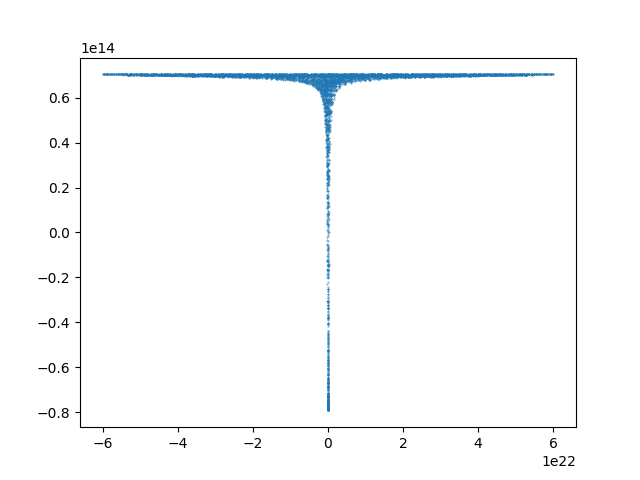

In [30]:
potential_individual_sum = sum_individual_contributions(mesh, origin, random_coordinates)

type(potential_individual_sum)

plt.figure()

# plt.scatter(x_coords, potential_individual_sum, s = 0.1)
plt.scatter(x_coords, potential, s=0.1)


<IPython.core.display.Javascript object>


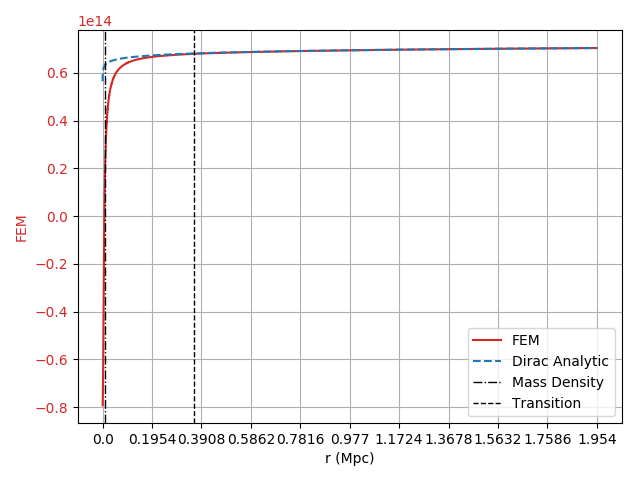

In [31]:
radial_plots_start = time.time()

#Defining analytic functions to check if the result is correct
#2nd argument of Heaviside is its value where the Heaviside goes from 0 to 1
potential_sphere_analytic = (np.heaviside(r_sorted - radius_tot, 0.5)*sqrt(G*mgb*a0)*np.log(r_sorted) +
(np.heaviside(radius_tot - r_sorted, 0.5))*(4/3*sqrt(pi/3*a0*G*mgb/volume_out)*np.power(r_sorted,3/2)+
sqrt(G*mgb*a0)*ln(radius_tot) - 4/3*sqrt(pi/3*a0*G*mgb/volume_out)*radius_tot**(3/2)))

#Analytic potential on the inside of a sphere
potential_inside_analytic = (4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*np.power(r_sorted,3/2)+
sqrt(G*mgb*a0)*ln(radius_tot) - 4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*radius_tot**(3/2))

#Analytic potential for a Dirac Delta
potential_dirac_analytic = sqrt(G*mgb*a0)*np.log(r_sorted)

#Analytic potential for multiple sources (scales with sqrt(#masses))
potential_multiple_dirac_analytic = sqrt(G*mgb*a0/source_number)*np.log(r_sorted)

#Analytic potentials for isothermal distribution
potential_isothermal_analytic = 2/3*sqrt(G*mgb*a0/6)*np.log(1 + np.power(r_sorted, 3/2)/p**(3/2))

#Plotting radial FEM solution and analytic solution on the same plot. We use subplots so'
#we can put multiple axes on the same plot and plot different scales
fig, potential1 = plt.subplots(sharex=True, sharey=True)

color = 'tab:red'
potential1.set_ylabel('FEM', color=color)

potential1.plot(r_sorted, potential_sorted, label = 'FEM', color=color, linestyle='-')

#Plotting the GEA potential as well
# potential1.plot(r_sorted, potential_GEA_sorted, label = 'FEM_GEA', color='tab:green', linestyle='--', linewidth=0.5)

potential1.tick_params(axis='y', labelcolor=color)

#UNCOMMENT TO HAVE SEPARATE AXES TO COMPARE SHAPES
# potential2 = potential1.twinx()
color = 'tab:blue'
# potential2.set_ylabel('Analytic', color=color)
plt.plot(r_sorted, potential_multiple_dirac_analytic, label = 'Dirac Analytic', linestyle = '--', )
# potential2.plot(r_sorted, potential_sphere_analytic, label = 'Dirac Analytic', linestyle = '--', color=color)

#It is possible to use Latex directly in the labels by enclosing expressions in $$
# plt.ylabel('$\phi$')

plot_annotations(potential1)

#Formatting plot using the function I made
plot_format(potential1,1,1)

potential1_title = f'potential_1_p{rank}'

#Saving the figure in the Figure folder, removed padding arounf with bbox_inches and. This is executed
#by each process, so uncomment if need to see solution from each process separately
# plt.savefig(f'Figures/{potential1_title}.pdf', bbox_inches='tight')


## Finding the error in the potential, radially

<IPython.core.display.Javascript object>


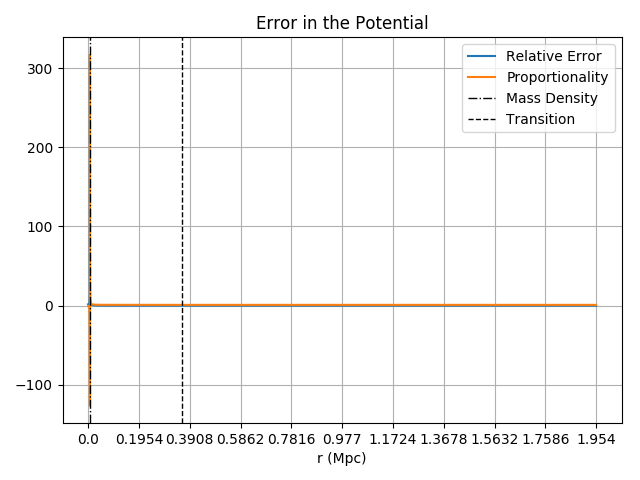

In [32]:
#for spherically symmetric mass distributions we have the anlytic solution, so we can compute
#the error
potential_error = np.abs((potential_sorted - potential_dirac_analytic)/potential_sorted)
potential_proportionality = potential_dirac_analytic/potential_sorted

#plotting the error against the radius
fig, plot_potential_error = plt.subplots(sharex=True, sharey=True)
plot_potential_error.plot(r_sorted,potential_error, label = 'Relative Error')
plot_potential_error.plot(r_sorted,potential_proportionality, label = 'Proportionality')
plt.title('Error in the Potential')
plot_annotations(plot_potential_error)
plot_format(plot_potential_error,1,1)

# Looking at the value of the potential along a specific axis. Useful when dealing with a non-radially symmetric distribution

<IPython.core.display.Javascript object>


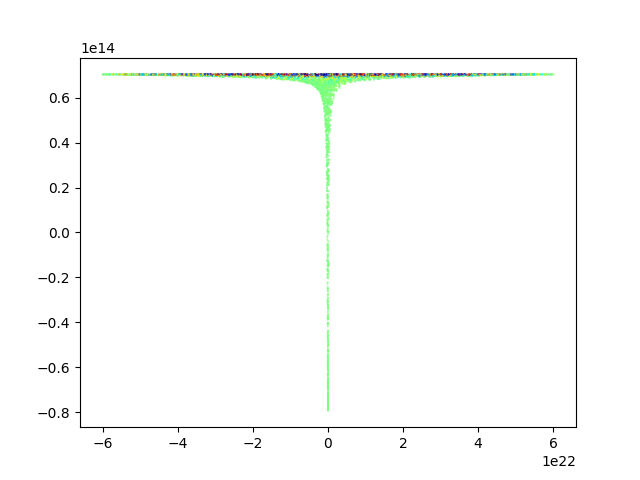

In [33]:
plt.figure()

plt.scatter(x_coords, potential, marker = '.', s = 0.5, c = y_coords/y_coords.max(), cmap = 'jet')


## Next, the acceleration

<IPython.core.display.Javascript object>


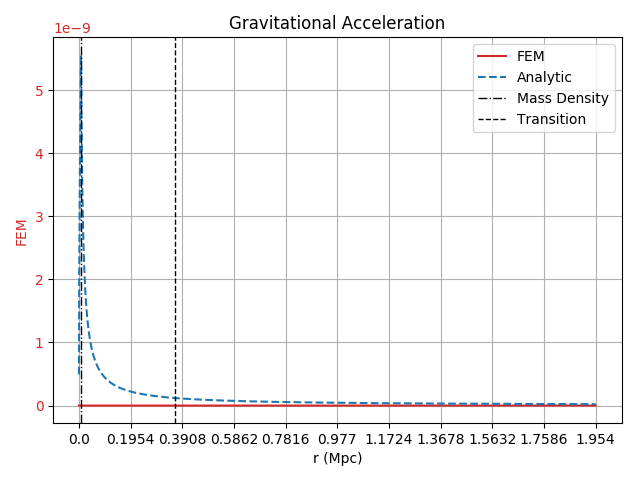

In [34]:
#Defining analytic functions to check if the result is correct
#2nd argument of Heaviside is its value where the Heaviside goes from 0 to 1
acceleration_sphere_analytic = (np.heaviside(r_sorted - radius_tot, 0.5)*sqrt(G*mgb*a0)*1/r_sorted+
(np.heaviside(radius_tot-r_sorted, 0.5))*4/3*sqrt(pi/3*a0*G*mgb/volume_out)*3/2*np.sqrt(r_sorted))

acceleration_dirac_analytic = sqrt(G*mgb*a0)*1/r_sorted

fig, acceleration1 = plt.subplots()

color = 'tab:red'
acceleration1.set_ylabel('FEM', color=color)

acceleration1.tick_params(axis='y', labelcolor=color)

#Plotting radial FEM solution and analytic solution on the same plot
acceleration1.plot(r_sorted, acceleration_magnitude_sorted, label = 'FEM', color = color)

#UNCOMMENT TO HAVE SEPARATE Y AXES
# acceleration2 = acceleration1.twinx()
color = 'tab:blue'
# acceleration2.set_ylabel('Analytic', color=color)

plt.plot(r_sorted, acceleration_sphere_analytic, label = 'Analytic', linestyle = '--', color = color)
plt.title('Gravitational Acceleration')

plot_annotations(acceleration1)

#Formatting plot using the function I made
plot_format(acceleration1,1,1)

## Finding the error in the acceleration

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


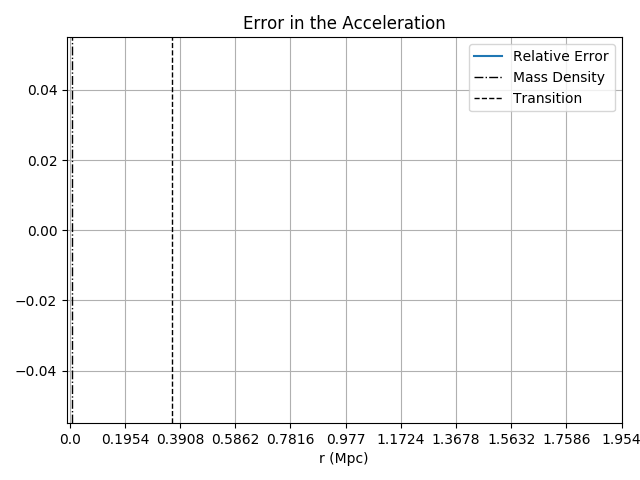

In [35]:
#for spherically symmetric mass distributions we have the anlytic solution, so we can compute
#the error
acceleration_error = np.abs((acceleration_magnitude_sorted - acceleration_dirac_analytic)/acceleration_magnitude_sorted)

#plotting the error against the radius
fig, acceleration_error_plot = plt.subplots()
acceleration_error_plot.plot(r_sorted,acceleration_error, label = 'Relative Error')
plt.title('Error in the Acceleration')
plot_annotations(acceleration_error_plot)
plot_format(acceleration_error_plot,1,1)

## Plotting the actual mass distribution that we input in the PDE, correpsonding to the baryonic matter

<IPython.core.display.Javascript object>


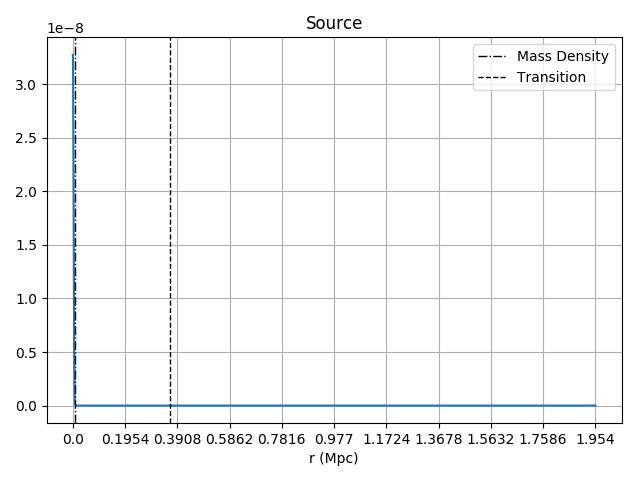

In [36]:
fig, source_radial_plot = plt.subplots()

#Scaling the mass distribution by 4*pi*G to get rho itself
source_radial_plot.plot(r_sorted, 1/(4*pi*G)*source_sorted)

plt.title('Source')
plot_annotations(source_radial_plot)
plot_format(source_radial_plot,1,1)

# Plotting the laplacian of the solution, that for MOND corresponds to the total matter distribution, baryons+dark matter. For Newton it should correspond to the mass distribution that we input in the PDE

<IPython.core.display.Javascript object>


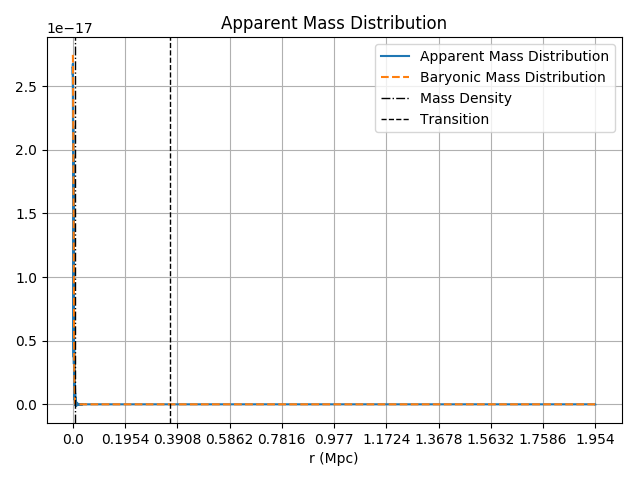

In [37]:
fig, apparent_mass_plot = plt.subplots()

plot_together = True

#Scaling the mass distribution by 4*pi*G to get rho itself
apparent_mass_plot.plot(r_sorted, apparent_mass_distribution_sorted, label = 'Apparent Mass Distribution')

if plot_together == True:
    
    apparent_mass_plot.plot(r_sorted, source_sorted, label = 'Baryonic Mass Distribution', linestyle='--')

plt.title('Apparent Mass Distribution')
plot_annotations(apparent_mass_plot)
plot_format(apparent_mass_plot,1,1)

<IPython.core.display.Javascript object>


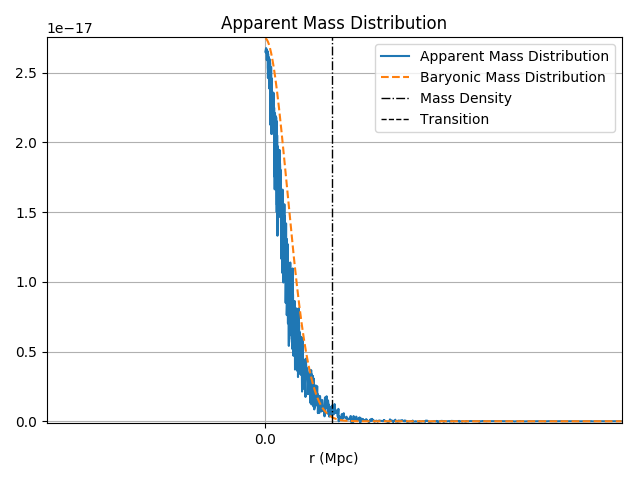

In [38]:
if rank == 0:

    fig, apparent_mass_total_plot = plt.subplots()

    #Scaling the mass distribution by 4*pi*G to get rho itself
    apparent_mass_total_plot.plot(r_total_sorted, apparent_mass_total_sorted, label = 'Apparent Mass Distribution')

    apparent_mass_total_plot.plot(r_total_sorted, source_total_sorted, label = 'Baryonic Mass Distribution', linestyle='--')

    plt.title('Apparent Mass Distribution')
    plot_annotations(apparent_mass_total_plot)
    plot_format(apparent_mass_total_plot,1,1)
    
    #Saving the figure in the Figure folder, removed padding arounf with bbox_inches and 
    plt.savefig(f'Figures/total_mass_distribution.pdf', bbox_inches='tight')

# Plotting the difference between the apparent mass distribution obtained as the Laplacian of the solution, and the baryonic mass distribution which is the RHS of the PDE

<IPython.core.display.Javascript object>


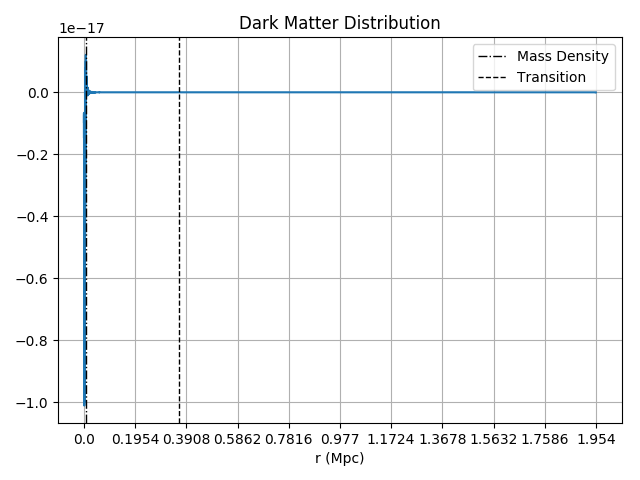

In [39]:
#The difference between apparent mass and baryonic mass is the dark matter distribution
dark_matter_density_sorted = (apparent_mass_distribution_sorted-source_sorted)

fig, dark_matter_density_plot = plt.subplots()

dark_matter_density_plot.plot(r_sorted, dark_matter_density_sorted)
plt.title('Dark Matter Distribution')
plot_annotations(dark_matter_density_plot)
plot_format(dark_matter_density_plot,1,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


<IPython.core.display.Javascript object>


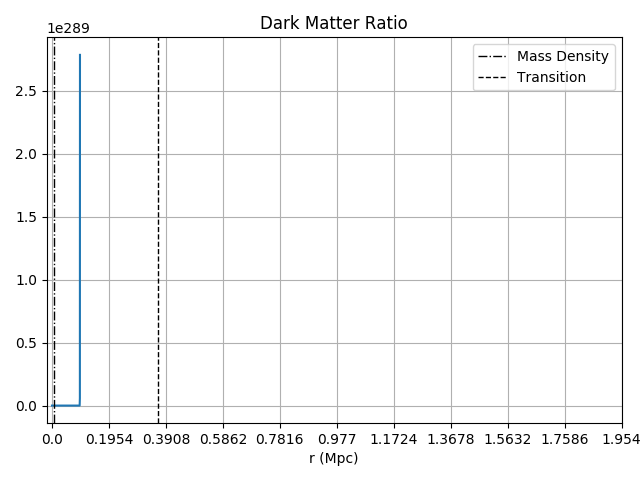

In [40]:
#The ratio between apparent mass and baryonic mass is the dark matter distribution
dark_matter_ratio_sorted = (apparent_mass_distribution_sorted/source_sorted)

fig, dark_matter_ratio_plot = plt.subplots()

dark_matter_ratio_plot.plot(r_sorted, dark_matter_ratio_sorted)
plt.title('Dark Matter Ratio')
plot_annotations(dark_matter_ratio_plot)
plot_format(dark_matter_ratio_plot,1,1)

## Histogram to look at the radial vertex distribution
### First, defining the function to do this

### Applying the function to the generated mesh

<IPython.core.display.Javascript object>


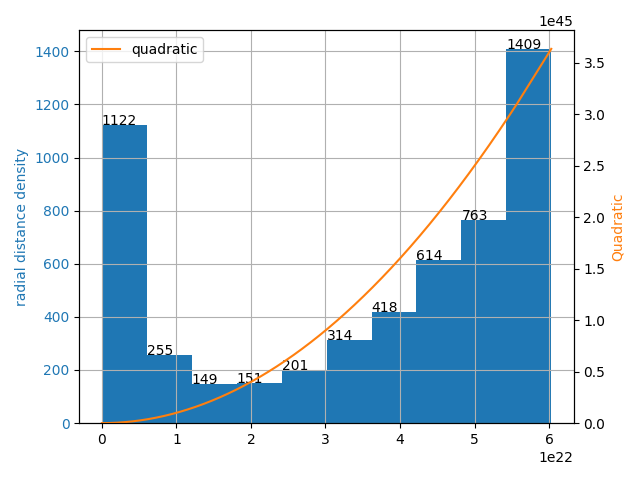

In [41]:
radial_dist_hist(r_sorted, mesh, False, 10)

radial_plots_end = time.time()
radial_plots_time = run_time(radial_plots_start - radial_plots_end, 'Radial Plots')
# section_times.append(radial_plots_time)

In [42]:
plots_3D_start = time.time()

if plot_3D_graphs: 

    #Have to first declare a figure and use its name as an input to the function
    #This way the plot can be plotted alongside other plots on the same grid
    whole_mesh = plt.figure()

    #Plotting the points 
    plot_mesh(mesh, Point(center_of_mass), degree_PDE, whole_mesh, 1, acceleration_magnitude_sorted, show_mesh=True, alpha = 0.3)

## For non spherically symmetric meshes, and for visual clarity, taking a slice of the mesh and plotting it in 2D

In [43]:
if plot_3D_graphs: 
    
    mesh_plane = plt.figure()
    plot_mesh_slice(20, mesh_plane, mesh, Point(center_of_mass), degree_PDE, random_coordinates, height = center_of_mass_z, portion = True, cross_section=True, show_source=True)

In [44]:
if plot_3D_graphs:

    trisurf_potential = plt.figure()
    trisurf_function_slice(trisurf_potential, potential, 20, center_of_mass_z, mesh, Point(center_of_mass), degree_PDE)
    plt.title('Potential in xy-plane')

In [45]:
if (plot_3D_graphs and acceleration_needed):  
    
    trisurf_acceleration = plt.figure()
    trisurf_function_slice(trisurf_acceleration, acceleration_magnitude, 20, center_of_mass_z, mesh, Point(center_of_mass), degree_PDE)
    plt.title('Acceleration in xy-plane')

In [46]:
# trisurf_source = plt.figure()
# trisurf_function_slice(trisurf_source, source, 20, center_of_mass_z, high_low = 'high')
# plt.title('Source in xy-plane')

## Plotting contour lines of the potential, so we can do that for different values of z and see the whole domain.

<IPython.core.display.Javascript object>


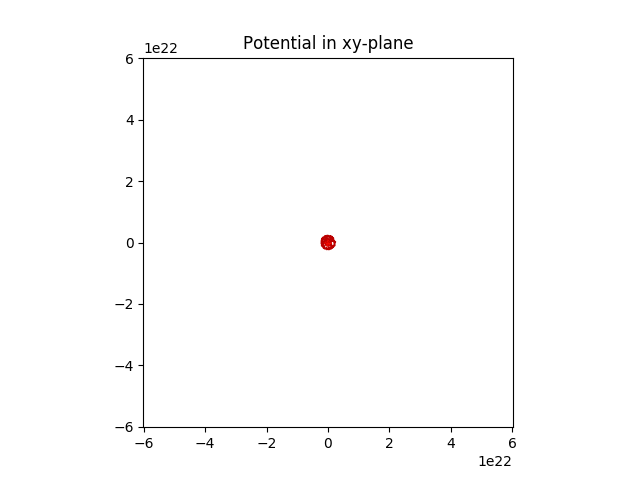

Text(0.5, 1.0, 'Potential in xy-plane')

In [47]:
tricontour_potential = plt.figure()
tricontour_function_slice(tricontour_potential, potential, Point(center_of_mass), 20, 20, center_of_mass_z, mesh, degree_PDE)
plt.title('Potential in xy-plane')

In [48]:
if acceleration_needed:

    tricontour_acceleration = plt.figure()
    tricontour_function_slice(tricontour_acceleration, acceleration_magnitude, Point(center_of_mass), 20, 20, center_of_mass_z, mesh, degree_PDE)
    plt.title('Acceleration in xy-plane')

<IPython.core.display.Javascript object>


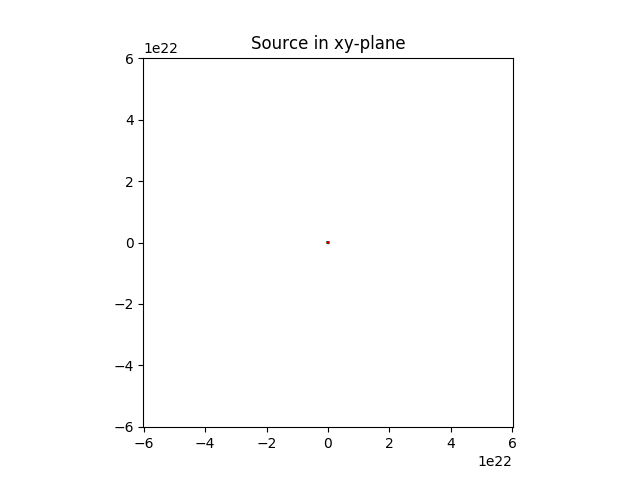

Text(0.5, 1.0, 'Source in xy-plane')

In [49]:
tricontour_source = plt.figure()
tricontour_function_slice(tricontour_source, source, Point(center_of_mass), 20, 20, center_of_mass_z, mesh, degree_PDE)
plt.title('Source in xy-plane')

## Making a function to plot slices and view them in 3D
### The 2 cells below this on contain the call to the function

In [50]:
#IMPORTANT: Right now, using a predefined amount of contours for each level, but this means
#that the colors ar enot consistent between different levels! So want to change it that instead
#of a numebr of contours, we have contours at specific values! That way the plot makes sense,
#and it will also look like a sphere since the max potential will be at the boundary, which 
#becomes smaller for each level.

# potential_slices = plt.figure()

# contour_3D_slices(potential_slices, potential, 100, 0)

In [51]:
# acceleration_slices = plt.figure()

# contour_3D_slices(acceleration_slices, acceleration_magnitude, 100, 0)

In [52]:
# source_slices = plt.figure()

# contour_3D_slices(source_slices, source, 100, 0)

## Looking at a quiver plot of the acceleration (useful when having multiple masses)

<IPython.core.display.Javascript object>


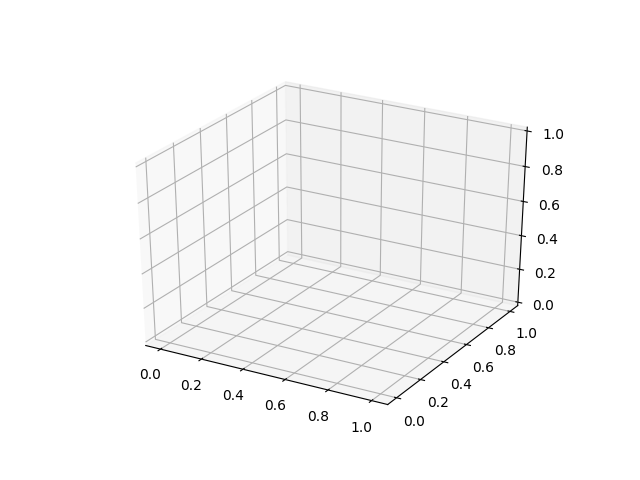

In [53]:
figure = plt.figure()

quivers = figure.add_subplot(111, projection='3d')

quivers.quiver(x_coords, y_coords, z_coords, acceleration_x, acceleration_y, acceleration_z, length=domain_size, normalize = False)


In [54]:
plots_3D_end = time.time()
plots_3D_time = run_time(plots_3D_end - plots_3D_start, '3D Plots')
section_times.append(plots_3D_time)

## Plotting the times taken by each section to profile the code

<IPython.core.display.Javascript object>


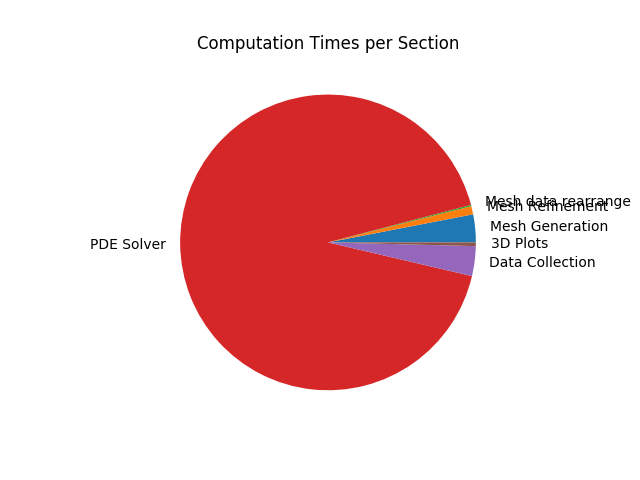

Text(0.5, 1.0, 'Computation Times per Section')

In [55]:
plt.figure()
pie_name = [section.name for section in section_times]
pie_time = np.zeros((len(section_times),1))

#can't use a list comprehension as for pie_name to make a numpy array, cause it makes
#a list instead! and for numbers it's always best to work with numpy 
for i, section in enumerate(section_times):
    pie_time[i] = section.time
    
#percentage of time taken, to display on the pie chart
pie_time_percent = [pie_time/(pie_time.sum()*100)]

#plotting the pie chart
plt.pie(pie_time, labels = pie_name)
# plt.legend()
plt.title('Computation Times per Section')

In [56]:
print(f'Overall time taken for process {rank}: {time.time() - starting_time} s \n')

Overall time taken for process 0: 86.83487629890442 s 



In [57]:
#Uncomment to close all figures so it doesnt take up all the memory
# plt.close('all')

# Other instance of main solver to either compare solutions or explore parameter space etc.

In [58]:
def compare_solutions(PDE_List, max_value, variable_name, samples, variable_title, title_units):
    '''This function accepts a list of BVP object, containing weak form, source, initial guess
    and name for a given BVP. Max value is the maximum value of a variable that is to be analysed,
    and looped over, variable_name is its name, samples is the amount of values to be taken between
    zero and max_value when looping over the variable, and variable_title is used to name subplots'''
    
    print(f'{variable_name} = {eval(variable_name)}')
    
    #Defining the amount of subplots needed from the samples input. We want samples/2 columns, and 2 rows
    #For it to work for odd numbers, we add the remainder of 2 so it's always divisible, then convert
    #to integer
    subplot_layout = (int((samples+samples%2)/2),2)
    
    #If we have only one sample, we make a plot with no subplots.
    if samples == 1:
    
        fig, potential_compare = (plt.subplots(sharex=True,sharey=True))
    
    else: 
        
        # Making a figure before we loop so all plots go in the same one. Sharing x,y axes per column/row
        #and getting rid of space inbetween graphs
        fig, potential_compare = (plt.subplots(subplot_layout[0],subplot_layout[1],sharex=True,sharey=True))
    #                                           gridspec_kw={'hspace': 0, 'wspace': 0}))
    
    #Defining an empty list to hold the solutions of each PDE, with #elements equal to samples
    u_list = [0 for sample in range(len(PDE_List))]

    #Defining a list of the potentials from the solution from each weak form
    potential_list = u_list

    #List for the sorted potentials
    potential_sorted_list = u_list
    
    #We loop over the chosen variable, going from its max_value/sample number to its max value
    for j, variable_value in enumerate(np.linspace(1,samples,samples)*max_value/samples):
        
        #Assigning the value of variable_value to the variable (e.g. standard deviation, #source etc.)
        #We need to evaluate it from here through te variable name in order for it to correctly pass it
        #to the c++ code in the solver. {variable name}. Must use exec, not eval for assignment
        exec(f'{variable_name} = {variable_value}')
        
        print(f'{variable_name} = {eval(variable_name)}')
        
        #If there are two or fewer subplots, the subplot index must actually be a number, not a tuple.
        #Either 0 or 1, so same as j.
        if samples <= 2:

            subplot_index = j
        
        else:
        
            #Converting the index i to binary, then using it to indicate the subplots to use [0,0], [0,1]
            # and so on
            subplot_index = ((int(j/2), j%2))
        
        #Looping over weak forms for the same initial guess and source
        for i, PDE in enumerate(PDE_List):
            
            #Putting the solutions in the u_list list
            u_list[i], f = solve_PDE(PDE)

            #Getting the potentials and sorted potentials for each solution
            potential_list[i] = u_list[i].compute_vertex_values()
            potential_sorted_list[i] = potential_list[i][sorting_index]
            
            #If we have the Newtonian potential, we add the difference at the boundary so they are on the
            #same part of the plot. Doesnt matter that we add a constant to the potential anyway
            if 'Newton' in PDE.name:
                
                potential_sorted_list[i] = (potential_sorted_list[i] + sqrt(G*mgb*a0)*ln(domain_size))
            
            #If we have only one sample, we plot on the plot itself, not a subplot
            if samples == 1:
                
                #Plot all the potentials on the same graph
                potential_compare.plot(r_sorted, potential_sorted_list[i], label = PDE.name)
            
            else:
            
                #Plot all the potentials on the same graph
                potential_compare[subplot_index].plot(r_sorted, potential_sorted_list[i], label = PDE.name)
        
        #Making a string for the title of each plot. The :.2E is to format the number in the title to be
        #in powers of 10.
        plot_title = f'${variable_title} = {(int(variable_value)):.1E} \: {title_units}$'
        
        #If we have only 1 sample, we need to call the function for the plot, rather than subplot
        if samples == 1:
        
            #Giving a title to each subplot
            potential_compare.set_title(plot_title)

            #Formatting each subplot after it's been filled with all the curves
            plot_format(potential_compare,1,1)
        
        else:

            potential_compare[subplot_index].set_title(plot_title)

            plot_format(potential_compare[subplot_index],1,1)
        
    return u_list, potential_sorted_list

## First, we compare the three interpolation functions (deep, simple, standard) for some different mass distributions.

In [59]:
#Lists of same source, different weak form.
BVP_dirac_list = [newton_dirac, mond_deep_dirac, mond_simple_dirac, mond_standard_dirac]
BVP_gauss_list = [newton_gauss, mond_deep_gauss, mond_simple_gauss, mond_standard_gauss]
BVP_continuous_list = [newton_continuous, mond_deep_continuous, mond_simple_continuous, mond_standard_continuous]

#list of same weak form, different source.
BVP_deep_list = [mond_deep_dirac, mond_deep_gauss, mond_deep_continuous]
BVP_simple_list = [mond_simple_dirac, mond_simple_gauss, mond_simple_continuous]
BVP_standard_list = [mond_standard_dirac, mond_standard_gauss, mond_standard_continuous]
BVP_newton_list = [newton_dirac, newton_gauss, newton_continuous]

if make_comparison:

    #Running the compare function
    discrete_list = compare_solutions(BVP_dirac_list, stand_dev, 'stand_dev', 1, '\sigma = ', 'Mpc')